# Test NBIRKGL16 with adaptive step size

<ul id="top">
    <li><a href="#Loading-packages-and-functions">Loading packages and functions</a></li>
    <li><a href="#Definition-of-the-N-body-problem">Definition of the N-body problem</a></li>
    <li><a href="#Memory-allocations">Memory allocations</a></li>
    <li><a href="#Error-in-Energy">Error-in-Energy</a></li>    
</ul>

## Loading packages and functions

In [1]:
using LinearAlgebra, Plots
using OrdinaryDiffEq
using NbodyIRKGL16

In [2]:
#to install NbodyIRKGL16.jl package
# using Pkg
# Pkg.add(url="https://github.com/mikelehu/NbodyIRKGL16.jl") 


#Local version
#      PATH_SRC="../src/"
#      include(string(PATH_SRC,"NbodyIRKGL16.jl"))
#      using .NbodyIRKGL16 



## Definition of the N-body problem

In Nbody.jl below, the following functions are defined: NbodyEnergy(u,Gm), NbodyODE!(du,u,Gm,t), and NbodyODE1!(du,u,Gm,t), where

\begin{equation*}
u = 
\left(\begin{matrix}
q_1  & v_1\\
\vdots & \vdots \\
q_N  & v_N
\end{matrix}
\right) \in \mathbb{R}^{2 \times 3\times N}, \quad
Gm = (G\,  m_1, \ldots,G\,  m_N) \in \mathbb{R}^N.
\end{equation*}

The energy, as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\mathrm{Energy}(q_1,\ldots,q_N,v_1,\ldots,v_N) = 
\frac12 \sum_{i=1}^{N} m_i \, \|v_i\|^2
- G \sum_{1\leq i < j \leq N} \frac{m_i m_j}{\|q_i-q_j\|}.
\end{split}
\end{equation*}


The ODE system of the N-body problem,
as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\frac{d}{dt} q_i &= v_i, \\
\frac{d}{dt} v_i &= G\, 
\sum_{j \neq i} \frac{m_j}{\|q_j-q_i\|^3}\,
(q_j-q_i).
\end{split}
\end{equation*}
This system of ODEs can be writen in compact form as
\begin{equation*}
\frac{d u}{dt} = f(t,u,Gm)
\end{equation*}




In [3]:
PATH_ODES="../ODEProblems/"

include(string(PATH_ODES,"Initial6Body.jl"))
include(string(PATH_ODES,"Nbody.jl"));

### Initial value problem: 6-body problem (outer solar system)

We consider $N=6$ bodies of the outer solar system: the Sun, Jupiter, Saturn, Uranus, Neptune and Pluto.
The initial values $u_{00}$ are taken from DE430, Julian day (TDB) 2440400.5 (June 28, 1969). 

In [4]:
u0, Gm, bodylist = Initial6Body(Float64)
u0_B, Gm_B, bodylist = Initial6Body(BigFloat)

q0=u0[:,:,1]
v0=u0[:,:,2]
dim=length(size(u0))

N = length(Gm)

show(bodylist)
E0=NbodyEnergy(u0,Gm)

["Sun" "Jupiter" "Saturn" "Uranus" "Neptune" "Pluto"]

-9.52262060596697e-12

##### <a href="#top">Back to the top</a>

## Memory allocations

In [5]:
t0 = 0.
dt = 500.  # 500.

Dtau=1.

tF = 200*dt
tF2 = 2*tF
tF4 = 4*tF

prob = ODEProblem(NbodyODE_with_step_size!, u0, (t0,tF), Gm)
prob2 = ODEProblem(NbodyODE_with_step_size!, u0, (t0,tF2), Gm)
prob4 = ODEProblem(NbodyODE_with_step_size!, u0, (t0,tF4), Gm);

### Adaptive version

#### IRKGL_seq (second_order_ode=false)

In [6]:
alg_seq=nbirkgl16(second_order_ode=false, simd=false)

solx=solve(prob, alg_seq,  adaptive=true, dt=Dtau, save_everystep=false)
solx2=solve(prob2,alg_seq, adaptive=true, dt=Dtau, save_everystep=false)
solx4=solve(prob4,alg_seq, adaptive=true, dt=Dtau, save_everystep=false);


In [7]:
println(solx.retcode,",tspan=",prob.tspan,",steps=",solx.destats.naccept,",length(solx.t)=",length(solx.t))
@time solve(prob,alg_seq, dt=Dtau, adaptive=true, save_everystep=false)
@time solve(prob,alg_seq, dt=Dtau, adaptive=true, save_everystep=false);

Success,tspan=(0.0, 100000.0),steps=285,length(solx.t)=2
  0.060175 seconds (88.91 k allocations: 6.030 MiB, 23.60% gc time, 75.80% compilation time)
  0.014473 seconds (5.86 k allocations: 315.438 KiB)


In [8]:
println(solx2.retcode,",tspan=",prob2.tspan,",steps=",solx2.destats.naccept,",length(solx2.t)=",length(solx2.t))
@time solve(prob2,alg_seq,dt=Dtau, adaptive=true, save_everystep=false);

Success,tspan=(0.0, 200000.0),steps=570,length(solx2.t)=2
  0.028365 seconds (5.86 k allocations: 315.438 KiB)


In [9]:
println(solx4.retcode,",tspan=",prob4.tspan,",steps=",solx4.destats.naccept,",length(solx4.t)=",length(solx4.t))
@time solve(prob4,alg_seq,dt=Dtau,  adaptive=true, save_everystep=false);

Success,tspan=(0.0, 400000.0),steps=1139,length(solx4.t)=2
  0.056629 seconds (5.86 k allocations: 315.438 KiB)


#### IRKNGL_seq (second_order_ode=true)

In [10]:
alg_seq=nbirkgl16(second_order_ode=true, simd=false)

solx=solve(prob, alg_seq,  adaptive=true, dt=Dtau, save_everystep=false)
solx2=solve(prob2,alg_seq, adaptive=true, dt=Dtau, save_everystep=false)
solx4=solve(prob4,alg_seq, adaptive=true, dt=Dtau, save_everystep=false);

In [11]:
println(solx.retcode,",tspan=",prob.tspan,",steps=",solx.destats.naccept,",length(solx.t)=",length(solx.t))
@time solve(prob,alg_seq, dt=Dtau, adaptive=true, save_everystep=false)
@time solve(prob,alg_seq, dt=Dtau, adaptive=true, save_everystep=false);

Success,tspan=(0.0, 100000.0),steps=285,length(solx.t)=2
  0.023091 seconds (32.15 k allocations: 2.147 MiB, 61.68% compilation time)
  0.008778 seconds (5.86 k allocations: 315.438 KiB)


In [12]:
println(solx2.retcode,",tspan=",prob2.tspan,",steps=",solx2.destats.naccept,",length(solx2.t)=",length(solx2.t))
@time solve(prob2,alg_seq,dt=Dtau, adaptive=true, save_everystep=false);

Success,tspan=(0.0, 200000.0),steps=570,length(solx2.t)=2
  0.018133 seconds (5.86 k allocations: 315.438 KiB)


In [13]:
println(solx4.retcode,",tspan=",prob4.tspan,",steps=",solx4.destats.naccept,",length(solx4.t)=",length(solx4.t))
@time solve(prob4,alg_seq,dt=Dtau,  adaptive=true, save_everystep=false);

Success,tspan=(0.0, 400000.0),steps=1139,length(solx4.t)=2
  0.034881 seconds (5.86 k allocations: 315.438 KiB)


### Simd version

#### IRKGL_simd (second_order_ode=false)

In [14]:
alg_simd=nbirkgl16(second_order_ode=false, simd=true)


solx=solve(prob, alg_simd,  adaptive=true, dt=Dtau, save_everystep=false)
solx2=solve(prob2,alg_simd, adaptive=true, dt=Dtau, save_everystep=false)
solx4=solve(prob4,alg_simd, adaptive=true, dt=Dtau, save_everystep=false);


In [15]:
println(solx.retcode,",tspan=",prob.tspan,",steps=",solx.destats.naccept,",length(solx.t)=",length(solx.t))
@time solve(prob,alg_simd, dt=Dtau, adaptive=true, save_everystep=false)
@time solve(prob,alg_simd, dt=Dtau, adaptive=true, save_everystep=false);

Success,tspan=(0.0, 100000.0),steps=285,length(solx.t)=2
  0.017381 seconds (32.15 k allocations: 2.141 MiB, 78.80% compilation time)
  0.003651 seconds (5.85 k allocations: 314.391 KiB)


In [16]:
println(solx2.retcode,",tspan=",prob2.tspan,",steps=",solx2.destats.naccept,",length(solx2.t)=",length(solx2.t))
@time solve(prob2,alg_simd,dt=Dtau, adaptive=true, save_everystep=false);

Success,tspan=(0.0, 200000.0),steps=570,length(solx2.t)=2
  0.006827 seconds (5.85 k allocations: 314.391 KiB)


In [17]:
println(solx4.retcode,",tspan=",prob4.tspan,",steps=",solx4.destats.naccept,",length(solx4.t)=",length(solx4.t))
@time solve(prob4,alg_simd,dt=Dtau,  adaptive=true, save_everystep=false);

Success,tspan=(0.0, 400000.0),steps=1139,length(solx4.t)=2
  0.013517 seconds (5.85 k allocations: 314.391 KiB)


#### IRKNGL_simd (second_order_ode=true)

In [18]:
alg_simd=nbirkgl16(second_order_ode=true, simd=true)

solx=solve(prob, alg_simd,  adaptive=true, dt=Dtau, save_everystep=false)
solx2=solve(prob2,alg_simd, adaptive=true, dt=Dtau, save_everystep=false)
solx4=solve(prob4,alg_simd, adaptive=true, dt=Dtau, save_everystep=false);

In [19]:
println(solx.retcode,",tspan=",prob.tspan,",steps=",solx.destats.naccept,",length(solx.t)=",length(solx.t))
@time solve(prob,alg_simd, dt=Dtau, adaptive=true, save_everystep=false)
@time solve(prob,alg_simd, dt=Dtau, adaptive=true, save_everystep=false);

Success,tspan=(0.0, 100000.0),steps=285,length(solx.t)=2
  0.016981 seconds (32.14 k allocations: 2.141 MiB, 87.23% compilation time)
  0.002086 seconds (5.85 k allocations: 314.391 KiB)


In [20]:
println(solx2.retcode,",tspan=",prob2.tspan,",steps=",solx2.destats.naccept,",length(solx2.t)=",length(solx2.t))
@time solve(prob2,alg_simd,dt=Dtau, adaptive=true, save_everystep=false);

Success,tspan=(0.0, 200000.0),steps=570,length(solx2.t)=2
  0.004110 seconds (5.85 k allocations: 314.391 KiB)


In [21]:
println(solx4.retcode,",tspan=",prob4.tspan,",steps=",solx4.destats.naccept,",length(solx4.t)=",length(solx4.t))
@time solve(prob4,alg_simd,dt=Dtau,  adaptive=true, save_everystep=false);

Success,tspan=(0.0, 400000.0),steps=1139,length(solx4.t)=2
  0.006961 seconds (5.85 k allocations: 314.391 KiB)


### Vern9

In [22]:
sol_Vern =solve(prob,Vern9(), dt=dt, save_everystep=false)
sol_Vern2 =solve(prob2,Vern9(), dt=dt, save_everystep=false)
sol_Vern4 =solve(prob4,Vern9(), dt=dt, save_everystep=false);


In [23]:
println(sol_Vern.retcode,",tspan=",prob.tspan,",steps=",prob.tspan[2]/dt,",length(sol_Vern.t)=",length(sol_Vern.t))
@time solve(prob,Vern9(),dt=dt, save_everystep=false);

Success,tspan=(0.0, 100000.0),steps=200.0,length(sol_Vern.t)=2
  0.000358 seconds (54 allocations: 10.047 KiB)


In [24]:
println(sol_Vern2.retcode,",tspan=",prob2.tspan,",steps=",prob2.tspan[2]/dt,",length(sol_Vern2.t)=",length(sol_Vern2.t))
@time solve(prob2,Vern9(),dt=dt, save_everystep=false);

Success,tspan=(0.0, 200000.0),steps=400.0,length(sol_Vern2.t)=2
  0.000651 seconds (54 allocations: 10.047 KiB)


In [25]:
println(sol_Vern4.retcode,",tspan=",prob4.tspan,",steps=",prob4.tspan[2]/dt,",length(sol_Vern4.t)=",length(sol_Vern4.t))
@time solve(prob4,Vern9(),dt=dt, save_everystep=false);

Success,tspan=(0.0, 400000.0),steps=800.0,length(sol_Vern4.t)=2
  0.001250 seconds (54 allocations: 10.047 KiB)


##### <a href="#top">Back to the top</a>



## Error in Energy

In [26]:
alg_seq=nbirkgl16(second_order_ode=false, simd=false)
alg_simd=nbirkgl16(second_order_ode=false, simd=true)

sol1=solve(prob,alg_seq,dt=Dtau, adaptive=true)
println(sol1.retcode,",length(sol1.t)=",length(sol1.t))

sol2=solve(prob,alg_simd,dt=Dtau, adaptive=true)
println(sol2.retcode,",length(sol2.t)=",length(sol2.t))

alg_seq=nbirkgl16(second_order_ode=true, simd=false)
alg_simd=nbirkgl16(second_order_ode=true, simd=true)

sol3=solve(prob,alg_seq,dt=Dtau, adaptive=true)
println(sol3.retcode,",length(sol3.t)=",length(sol3.t))

sol4=solve(prob,alg_simd,dt=Dtau, adaptive=true)
println(sol4.retcode,",length(sol4.t)=",length(sol4.t))

Success,length(sol1.t)=286
Success,length(sol2.t)=286
Success,length(sol3.t)=286
Success,length(sol4.t)=286


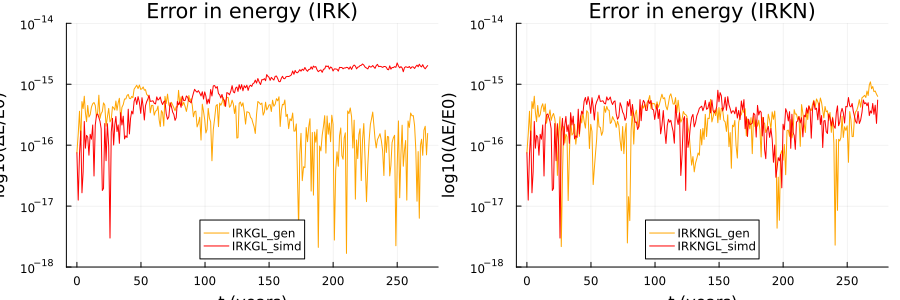

In [27]:
E0=NbodyEnergy(u0_B, Gm_B)
year=365.25
yrange=(1e-18,1e-14)
ΔE1 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), sol1.u)./E0.-1
ΔE2 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), sol2.u)./E0.-1
ΔE3 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), sol3.u)./E0.-1
ΔE4 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), sol4.u)./E0.-1


pl1=plot(title="Error in energy (IRK)",xlabel="t (years)", ylabel="log10(ΔE/E0)", 
     yscale=:log10, ylims=yrange, legend=:bottom)

plot!(pl1, sol1.t./year,abs.(ΔE1),label="IRKGL_gen", color="orange")
plot!(pl1, sol2.t./year,abs.(ΔE2),label="IRKGL_simd", color="red")

pl2=plot(title="Error in energy (IRKN)",xlabel="t (years)", ylabel="log10(ΔE/E0)", 
     yscale=:log10, ylims=yrange, legend=:bottom)

plot!(pl2, sol3.t./year,abs.(ΔE3),label="IRKNGL_gen", color="orange")
plot!(pl2, sol4.t./year,abs.(ΔE4),label="IRKNGL_simd", color="red")

plot(pl1, pl2, layout=(1,2), size=(900,300))